<a href="https://colab.research.google.com/github/namanh218/IMDB/blob/master/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text classification with an RNN

When we first learn machine learning, we have learnt to solve this problem with sklearn and logistic regression with softmax (multi-classes) or sigmond (binary-classes) as activation functions.

We'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
import matplotlib.pyplot as plt

# we use want to plot all metrics for every epochs
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## Download our dataset


The IMDB dataset is a **binary** classification dataset so all the reviews have either a **positive** or **negative** review.


In [0]:
# Use the version pre-encoded with an ~8k vocabulary.
dataset, info = tfds.load('imdb_reviews/subwords8k', 
                          
                          # Also return the `info` structure. 
                          with_info=True,

                          # Return (example, label) pairs from the dataset (instead of a dictionary).
                          as_supervised=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [0]:
train_dataset, test_dataset = dataset['train'], dataset['test']

## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review.

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [0]:
dataset.values()

dict_values([<_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>, <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>, <_OptionsDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>])

In [0]:
# print out first three sentences and its labels
for train_example, train_label in train_dataset.take(1):
  print('Encoded text:', train_example.numpy())
  print('Label:', train_label.numpy())

Encoded text: [ 249    4  277  309  560    6 6639 4574    2   12   31 7759 3525 2128
   93 2306   43 2312 2527    6   30 1334 8044   24   10   16   10   17
  977   30  815 3339   41  841 7911  376 7974 1923    6  607  219   44
  242 1603   11 4329  102 2821 1139    2  969  161   51   18    4 5844
 2820  123 4493   40    6 4571   13  117   35  289  850  455   50  460
 6359 1069  343   20    1 3733 3511 7670    3  147    4  336    2   42
   18    4 3422  409 3533  871 2836  311    5 5080 1209    3  183  117
   35 1187    5 1955   11    1  226 7745    3  183 1466 7359 7961 1466
  665    2 6854 3178 1377 6266 1447  297    2 5797   36 4740  847 8050
    2    5 1929 1631 5986   22 5541 5688    5 1036 3746 8050    3   69
  264   35    4 4224    2   26   42   18    4  474 7968    8 1626   24
   10   16   10   17  134   15    9    1  435   13    9   55  598 2357
   48   30 6611 8044    3  500    1  101    6 2793    2 6548 7961 5861
  311    9  139 5398 2270   11 3674 1642   25 7796 7961 5012   

 The dataset `info` includes the encoder (a `tfds.features.text.SubwordTextEncoder`). The encoder can be used to recover the original text.

In [0]:
encoder = info.features['text'].encoder

In [0]:
print('Unique vocabulary size: {}'.format(encoder.vocab_size))

Unique vocabulary size: 8185


This encoder can be trained on our current dataset.
This text encoder will reversibly encode any string.

Remember this, the encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be.


In [0]:
# Try "Hello TensorFlow." later and see the difference
sample_string = 'Chó'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))
print (type(encoded_string[0]))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [6995, 8124, 8108]
<class 'int'>
The original string: "Chó"


In [0]:
# see how the encoder match one index to a string, it is totally up to the encoder and the whole corpus dataset, also the target vocab size
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

6995 ----> Ch
8124 ----> �
8108 ----> �


In [0]:
assert original_string == sample_string  #make sure our decode string and encoded string is the same

Ok, let's cool, but can we decode our first review in our trainset ?


In [0]:
#Therefore, let's decode our first sentence 
original_sentence = encoder.decode(train_example.numpy())
print('The original sentence: "{}"'.format(original_sentence))

The original sentence: "As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. 

## Prepare the data for training

Next create batches of these encoded strings. Use the `padded_batch` method to zero-pad the sequences to the length of the longest string in the batch:

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

You will want to create batches of training data for your model. The reviews are all different lengths, so use padded_batch to zero pad the sequences while batching.

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length:

In [0]:
for example_batch, label_batch in train_dataset.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (64, 1284)
label shape: (64,)
Batch shape: (64, 1491)
label shape: (64,)


## Create the model

Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.

In [0]:
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=BUFFER_SIZE, output_dim=64))

# layer Embeddings (vocab_size, 64)
# Bi LSTM 64
model.add(layers.LSTM(64))
model.add(layers.Dense(64, activation = 'relu'))
# Dense 64 relu
# Dense 1 sigmoid
model.add(layers.Dense(1,activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 677,249
Trainable params: 677,249
Non-trainable params: 0
_________________________________________________________________


A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

Now, configure the model to use an optimizer and a loss function:

Compile the Keras model to configure the training process:

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [0]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 36s 91ms/step - loss: 0.6932 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5099
Epoch 2/2
391/391 [==============================] - 29s 74ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4896


And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 11s 29ms/step - loss: 0.6932 - accuracy: 0.5000Test Loss: 0.6932070974803641
Test Accuracy: 0.5


This fairly naive approach achieves an accuracy of about 85%.

The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would [use masking](../../guide/keras/masking_and_padding) to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [0]:
def sample_predict(sample_pred_text):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  
  encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [0]:
# predict on a positive sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text)
print(predictions)

[[0.50603324]]


In [0]:
# predict on a negative sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text)
print (predictions)

[[0.50603384]]


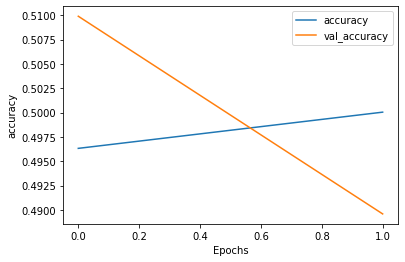

In [0]:
plot_graphs(history, 'accuracy')

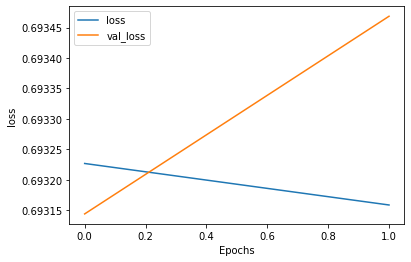

In [0]:
plot_graphs(history, 'loss')

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`).
* Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM, Embedding
model = tf.keras.Sequential([
    Embedding(encoder.vocab_size, 64),
    LSTM(100, return_sequences=True),
    # LSTM(64),
    Dense(1, activation = 'sigmoid'),
    # layer Embeddings (vocab_size, 64)
    # LSTM 64, return sequence ?
    # LSTM 64
    # Dense 64 relu
    # Dense 1 sigmoid

])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 34s 87ms/step - loss: 0.6918 - accuracy: 0.5187 - val_loss: 0.6914 - val_accuracy: 0.5487
Epoch 2/10
391/391 [==============================] - 32s 82ms/step - loss: 0.6698 - accuracy: 0.5713 - val_loss: 0.6808 - val_accuracy: 0.5449
Epoch 3/10
391/391 [==============================] - 33s 85ms/step - loss: 0.5968 - accuracy: 0.6836 - val_loss: 0.5552 - val_accuracy: 0.7567
Epoch 4/10
391/391 [==============================] - 33s 86ms/step - loss: 0.5097 - accuracy: 0.7905 - val_loss: 0.5143 - val_accuracy: 0.7862
Epoch 5/10
391/391 [==============================] - 33s 85ms/step - loss: 0.4989 - accuracy: 0.7875 - val_loss: 0.4805 - val_accuracy: 0.7945
Epoch 6/10
391/391 [==============================] - 34s 87ms/step - loss: 0.6767 - accuracy: 0.7222 - val_loss: 0.6526 - val_accuracy: 0.6002
Epoch 7/10
391/391 [==============================] - 34s 88ms/step - loss: 0.6312 - accuracy: 0.6255 - val_loss: 0.6380 - val_accuracy:

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           65        
Total params: 556,929
Trainable params: 556,929
Non-trainable params: 0
_________________________________________________________________


In [0]:
test_loss, test_acc = model.evaluate(test_dataset)


print('Test Loss: {}'.format(test_loss))

print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 11s 28ms/step - loss: 0.4397 - accuracy: 0.8318Test Loss: 0.43970636844330124
Test Accuracy: 0.8317813277244568


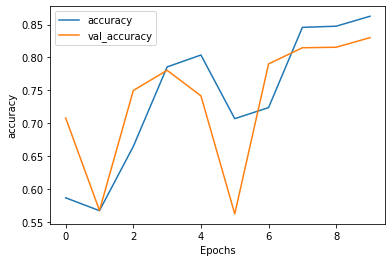

In [0]:
plot_graphs(history, 'accuracy')

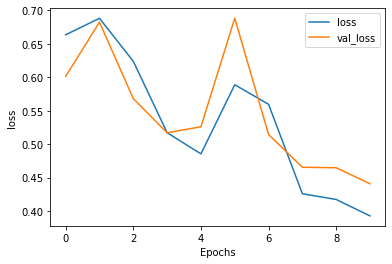

In [0]:
plot_graphs(history, 'loss')